In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
registros_filtrados = pd.read_excel("registros_filtrados.xlsx")
sensores = pd.read_excel("../sensores_airenuevoleon.xlsx")

# Análisis de Lecturas Atípicas y Consistencia


## Introducción
Breve texto sobre el objetivo del análisis y la metodología usada

### ¿Cómo interpretar los intervalos de confianza 1σ, 2σ, 3σ?

Para cada sensor ANL, calculamos la media y la desviación estándar de las lecturas de PM2.5.  
Las líneas de colores en cada gráfico representan los siguientes límites estadísticos:

- **±1σ (naranja)**: abarca aproximadamente el 68% de los datos esperados
- **±2σ (rojo)**: abarca el 95% de los datos esperados
- **±3σ (morado)**: abarca el 99.7% de los datos esperados

Valores que se encuentran por fuera de estas bandas son **posibles lecturas atípicas o inconsistentes**, especialmente si ocurren con frecuencia o en múltiples sensores.

Esto permite validar la estabilidad del sensor y detectar problemas de lectura o condiciones ambientales extremas.


**Nota:** Aunque los intervalos de confianza calculados incluyen valores negativos, estos no representan concentraciones reales de contaminantes. Se muestran únicamente como referencia estadística.

# PM2.5

### Calidad de los Datos – PM2.5

Antes de analizar la variabilidad con intervalos de confianza, evaluamos la calidad de las mediciones de PM2.5 por sensor ANL.
El siguiente resumen muestra el porcentaje de lecturas faltantes (nulas) y lecturas inconsistentes (valores negativos).

In [ ]:
# Total de registros 
total = registros_filtrados.groupby("Sensor_id")["PM25"].count()

# Nulos
nulos = registros_filtrados["PM25"].isnull().groupby(registros_filtrados["Sensor_id"]).sum()

# Inconsistentes (< 0)
inconsistentes = registros_filtrados["PM25"].lt(0).groupby(registros_filtrados["Sensor_id"]).sum()

calidad_pm25 = pd.DataFrame({
    "Total registros": total,
    "Nulos": nulos,
    "Inconsistentes (<0)": inconsistentes
})

calidad_pm25["% Nulos"] = (calidad_pm25["Nulos"] / calidad_pm25["Total registros"] * 100).round(2)
calidad_pm25["% Inconsistentes"] = (calidad_pm25["Inconsistentes (<0)"] / calidad_pm25["Total registros"] * 100).round(2)

calidad_pm25 = calidad_pm25.fillna(0).sort_values(by="% Nulos", ascending=False)
calidad_pm25


,Total registros,Nulos,Inconsistentes (<0),% Nulos,% Inconsistentes
Sensor_id,,,,,
ANL15,512,32231,469,6295.12,91.60
ANL16,609,14314,511,2350.41,83.91
ANL7,32839,23998,33,73.08,0.10
ANL11,36208,20650,62,57.03,0.17
ANL9,40006,16857,14,42.14,0.03
ANL6,40946,15888,14,38.80,0.03
ANL10,41479,15387,22,37.10,0.05
ANL12,42150,14703,8,34.88,0.02
ANL13,42246,14607,11,34.58,0.03


## Distribución - PM2.5
Esta sección analiza la distribución de los valores de PM2.5 por sensor ANL, aplicando intervalos de confianza con 1σ, 2σ y 3σ (desviación estándar).
Esto nos permite detectar posibles lecturas atípicas o inconsistentes que se desvían significativamente de los valores esperados.

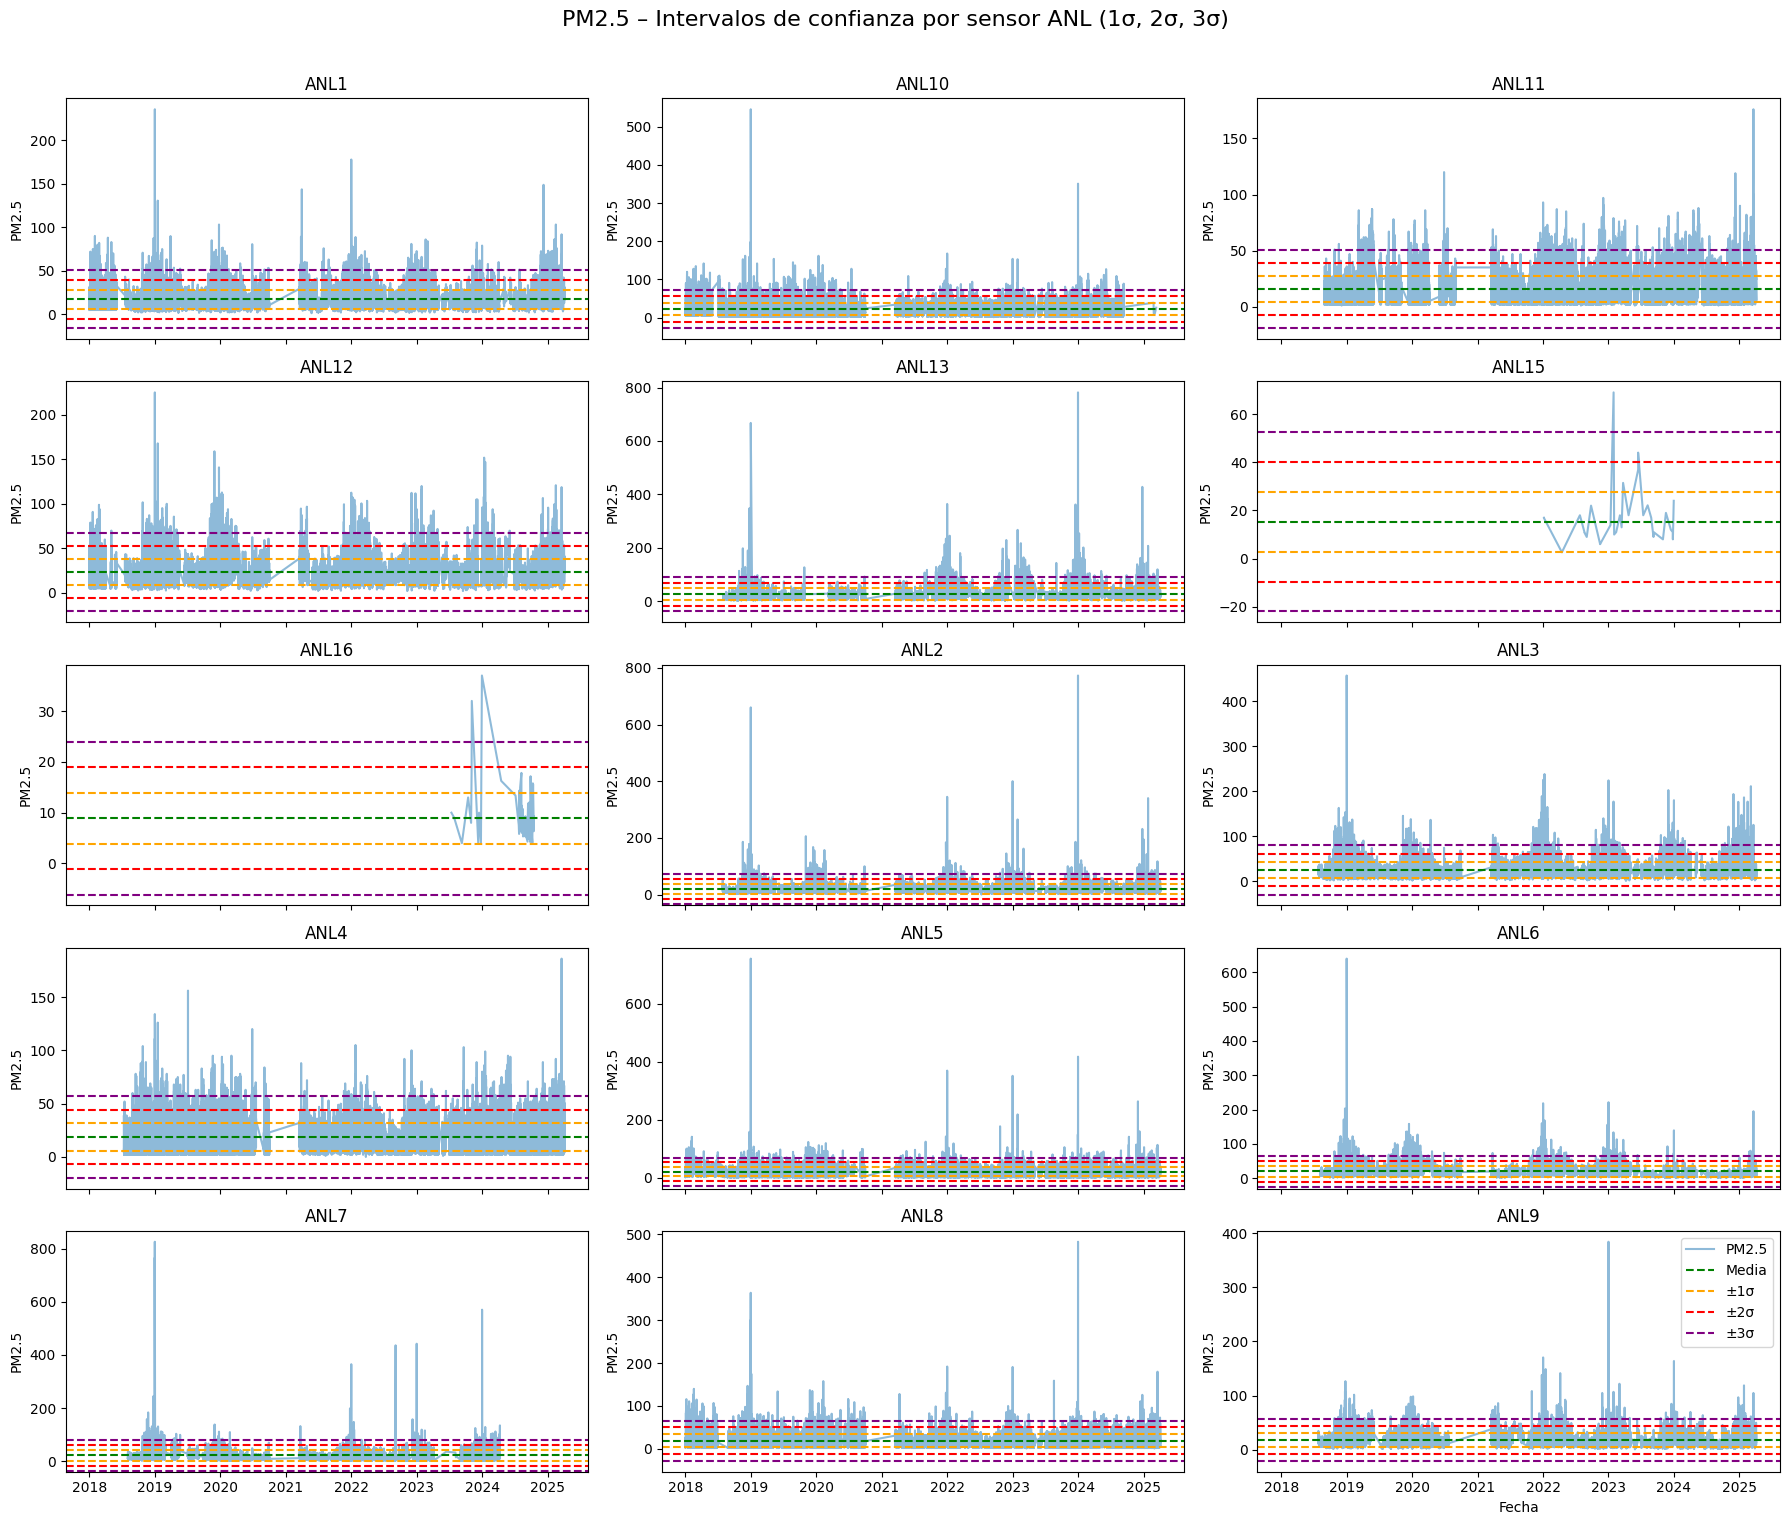

In [8]:
# Calcular estadísticas solo con valores válidos
pm25_validos = registros_filtrados[(registros_filtrados["PM25"] >= 0)]
estadisticas_pm25 = pm25_validos.groupby("Sensor_id")["PM25"].agg(["mean", "std"]).dropna()

# Lista de sensores ANL
sensores_anl = sensores["Sensor_id"].unique()

# Filtrar registros válidos de sensores ANL
registros_pm25_anl = pm25_validos[pm25_validos["Sensor_id"].isin(sensores_anl)]

# Graficar por sensor
fig, axs = plt.subplots(nrows=5, ncols=3, figsize=(18, 16), sharex=True)
axs = axs.flatten()

for i, sensor in enumerate(sensores_anl):
    df = registros_pm25_anl[registros_pm25_anl["Sensor_id"] == sensor]
    
    if df.empty or sensor not in estadisticas_pm25.index:
        continue

    media = estadisticas_pm25.loc[sensor, "mean"]
    std = estadisticas_pm25.loc[sensor, "std"]

    axs[i].plot(df["Dia"], df["PM25"], label="PM2.5", alpha=0.5)
    axs[i].axhline(media, color="green", linestyle="--", label="Media")
    axs[i].axhline(media + std, color="orange", linestyle="--", label="±1σ")
    axs[i].axhline(media - std, color="orange", linestyle="--")
    axs[i].axhline(media + 2*std, color="red", linestyle="--", label="±2σ")
    axs[i].axhline(media - 2*std, color="red", linestyle="--")
    axs[i].axhline(media + 3*std, color="purple", linestyle="--", label="±3σ")
    axs[i].axhline(media - 3*std, color="purple", linestyle="--")
    axs[i].set_title(sensor)
    axs[i].set_ylabel("PM2.5")

plt.suptitle("PM2.5 – Intervalos de confianza por sensor ANL (1σ, 2σ, 3σ)", fontsize=16)
plt.xlabel("Fecha")
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.legend(loc="upper right")
plt.show()
